<a href="https://colab.research.google.com/github/sjosephnyc1987/public_ipython_Notebooks/blob/main/DAL_FXXP_TickData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FXXP Tick Data

## **Prep**

Our overall goal in filtering Tick data is as follows

1.Remove any Rows with Null Values

2.Remove a Lot that is 0 or Negative

3.Remove any instructions that are not 'Bid' or 'Ask;

4.Visually look at the chart (optional)

5.Remove any outliers that are outside of a 2 std deviation threshold

6.Remove any "cross market quotes"! (Bid = Offer) in the same Timeframe

7.Remove any quotes where Bid > Offer 8.Remove Bid-Ask Bounce

In [ ]:

#initializations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

#this is a terrible practice and dont do it
import warnings
warnings.filterwarnings("ignore")


Mounted at /content/drive


In [ ]:
filepath = "/content/drive/MyDrive/TEMPO/datasets/FXXP_Tick_Data.csv"

df2 = pd.read_csv(filepath,sep='\t', header=0)

original_size = len(df2)
print("original dataframe size = ", original_size)

#Let's look at the first 10 rows
print(df2.head(10))

original dataframe size =  7930
                    Id  Index Type              TimestampUtc  Size  Value
0 -9223372033721472385      1  Bid  20101203 08:01:34.731600     0  270.0
1 -9223372033721472373      2  Ask  20101203 08:08:42.914736    40  272.4
2 -9223372033721472367      3  Bid  20101203 08:09:08.806047    40  271.1
3 -9223372033721472365      4  Bid  20101203 08:09:11.579957    40  271.1
4 -9223372033721472363      5  Ask  20101203 08:09:13.882389    40  272.3
5 -9223372033721472361      6  Ask  20101203 08:09:14.755620    40  272.2
6 -9223372033721472360      7  Bid  20101203 08:09:14.755620     0  271.0
7 -9223372033721472355      8  Bid  20101203 08:09:24.586466    80  270.8
8 -9223372033721472354      9  Ask  20101203 08:09:24.855967    40  272.1
9 -9223372033721472353     10  Bid  20101203 08:09:24.855967    40  270.9


In [ ]:
#next let's see if there are any nulls and if so we should remove them
df2.isnull().sum()

Id              0
Index           0
Type            0
TimestampUtc    0
Size            0
Value           0
dtype: int64

In [ ]:
#There appear to be some lots with Size of 0 and Negative, let's remove those and assign to a new dataframe df2_Size0_Removed
#as they appear to be artefacts
df2_Size0_Removed = df2[df2['Size']>0]

In [ ]:
#Let's look at the first 10 rows again
print(df2_Size0_Removed.head(10))

                     Id  Index Type              TimestampUtc  Size  Value
1  -9223372033721472373      2  Ask  20101203 08:08:42.914736    40  272.4
2  -9223372033721472367      3  Bid  20101203 08:09:08.806047    40  271.1
3  -9223372033721472365      4  Bid  20101203 08:09:11.579957    40  271.1
4  -9223372033721472363      5  Ask  20101203 08:09:13.882389    40  272.3
5  -9223372033721472361      6  Ask  20101203 08:09:14.755620    40  272.2
7  -9223372033721472355      8  Bid  20101203 08:09:24.586466    80  270.8
8  -9223372033721472354      9  Ask  20101203 08:09:24.855967    40  272.1
9  -9223372033721472353     10  Bid  20101203 08:09:24.855967    40  270.9
10 -9223372033721472349     11  Bid  20101203 08:09:55.698155    80  270.8
11 -9223372033721472347     12  Bid  20101203 08:10:03.673333    80  270.8


Entries of Index 7 and 1 from the first 10 rows had size 0, they seem to be gone and so we're on the right track

In [ ]:
#we do a sanity check and look at the lenght of the dataframe now
print("current dataframe size = ", len(df2_Size0_Removed))
print("entries removed = ", original_size - len(df2_Size0_Removed))

current dataframe size =  6125
entries removed =  1805


In [ ]:
#next we look for bad instruction types and remove them if needed
print(df2_Size0_Removed['Type'].value_counts())

Ask      3361
Bid      2741
Trade      22
I           1
Name: Type, dtype: int64


We see a Type of "I" (and others) and so we remove them

In [ ]:
df2_inst_Removed = df2_Size0_Removed[(df2_Size0_Removed['Type']=="Bid") | (df2_Size0_Removed['Type']=="Ask") | (df2_Size0_Removed['Type']=="Trade")]

In [ ]:
#let's look at the lenght of the dataframe now
print(len(df2_inst_Removed))
print("--------")

#and the valuecounts again
print(df2_inst_Removed['Type'].value_counts())

6124
--------
Ask      3361
Bid      2741
Trade      22
Name: Type, dtype: int64


In [ ]:
#for ease of handling we assign it to df3
df3 = df2_inst_Removed.copy()

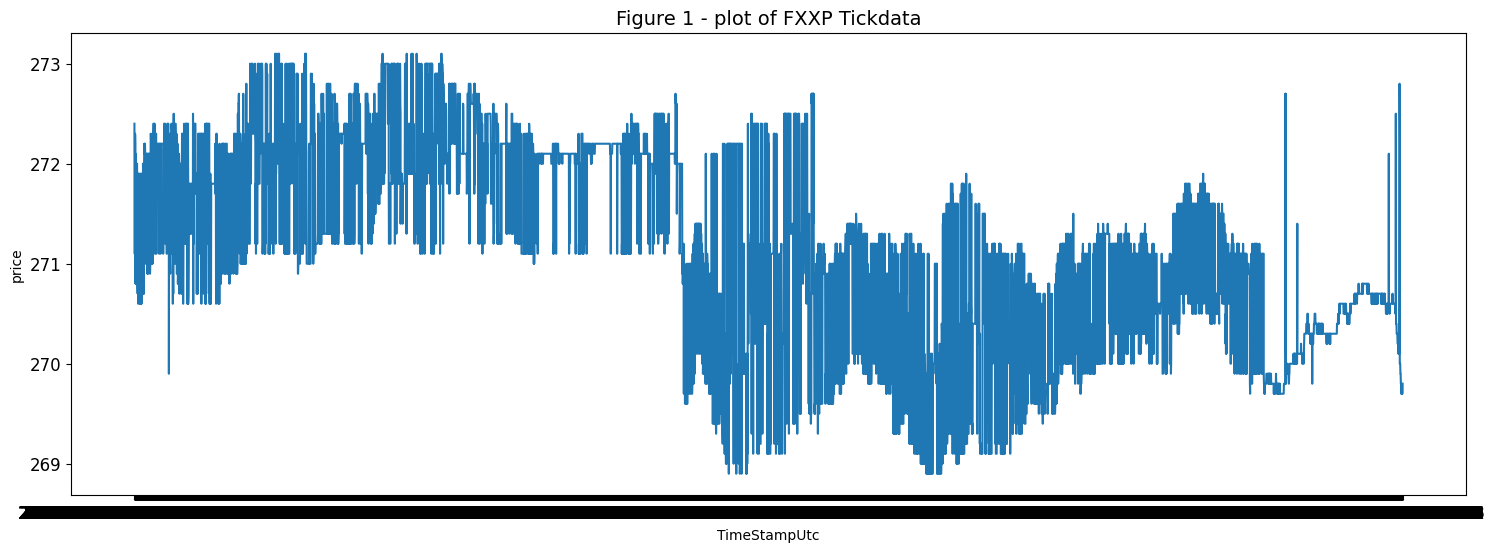

In [ ]:
#Next we plot this data to get a visual impression

# Extract the date and close price columns
timestamp = df3['TimestampUtc']
price = df3['Value']

# Create a line plot
plt.plot(timestamp, price)
#plt.scatter(portfolio_vol,portfolio_exp_returns, c="hotpink")
plt.xlabel("TimeStampUtc", fontsize=10)
plt.ylabel("price", fontsize=10)
plt.title(f"Figure 1 - plot of FXXP Tickdata",fontsize =14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rcParams['figure.figsize'] = [25, 6]

# Show the plot
plt.show()

Data shows outliers, so we'll set a limit to remove them and refine the analysis, but be cautious: outliers might hold valuable information, so removing them blindly can introduce bias. Think before you filter!

Although there is some overlap in Bid and Offer prices, not separating them will cause good quotes to drop out and so we separate the Bids, Asks and Trades before we do the comparison to the rolling media

In [ ]:
#separating  the bids and offers
df3_bid = df3[df3['Type']=='Bid']
df3_ask = df3[df3['Type']=='Ask']
df3_trade = df3[df3['Type']=='Trade']

In [ ]:
df3_bid['rolling_std_10']=df3_bid['Value'].rolling(10).std()
df3_ask['rolling_std_10']=df3_ask['Value'].rolling(10).std()
df3_trade['rolling_std_10']=df3_trade['Value'].rolling(10).std()

df3_bid['rolling_mean_10']=df3_bid['Value'].rolling(10).mean()
df3_ask['rolling_mean_10']=df3_ask['Value'].rolling(10).mean()
df3_trade['rolling_mean_10']=df3_trade['Value'].rolling(10).mean()

## **Filtering the data**
From scientific literature, we see that the best way to filter outliers is to use a moving threshold of some kind.

Our logic is as follows

1.   We generate a moving standard deviation of window size = 10.
2.   We generate a moving average of window size = 10
3.   We generate a Top-Line and Bottom-Line threshold of 10-Moving-Average (step2)  plus or minus 10-day-std-dev (step 1)
4.  If tick data lies outside this threshold, we reject it as artefact.

This approach is similar to Bollinger Band support and resistance levels, and is typically driven by the research department. (A little out of scope for our exercise here)

Although Tick Data is not Lognormal, we're using Variance as a tool to filter. This does'nt break our fundamental assumption, but note that we're not saying that the underlying distribution is Normal, we're saying that the distribution of 'Artefacts' is

Although I've taken window size = 10, the right value is somewhat dynamically obtained and is typically arrived at depending on Price Categories, Notional values etc

This logic only makes sense if there are more than 20 entries and so we don't filter outliers unless there are at least 20 entries.

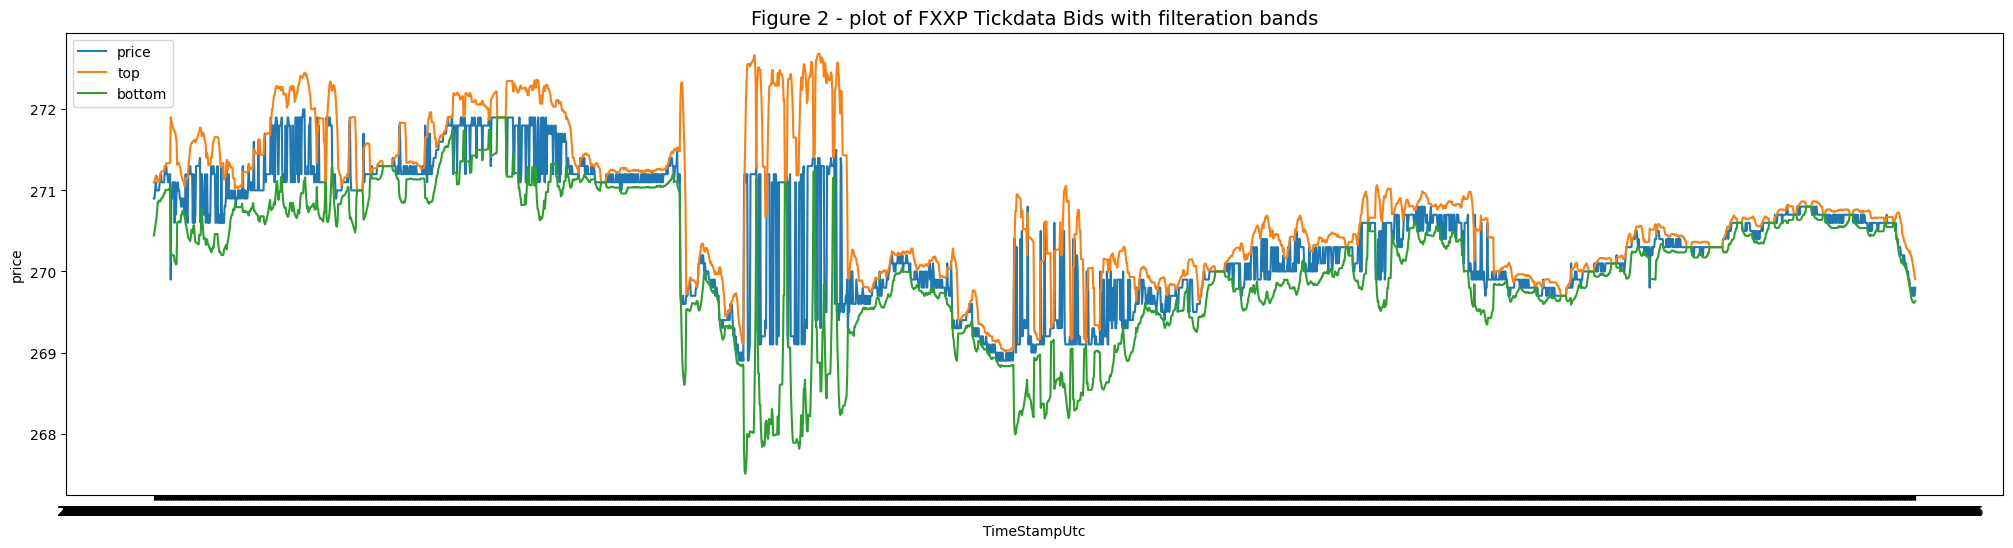

In [ ]:
if len(df3_bid) > 20 :

    df3_bid['rolling_median_3']=df3_bid['Value'].rolling(3).median()
    df3_bid['rolling_mean_10']=df3_bid['Value'].rolling(10).mean()
    df3_bid['rolling_std_10']=df3_bid['Value'].rolling(10).std()

    df3_bid = df3_bid.dropna()

    df3_bid['topline'] = df3_bid['rolling_mean_10'] + 2*df3_bid['rolling_std_10']  #filter band top = Rolling means + 2 x Moving Std Deviation
    df3_bid['bottomline'] = df3_bid['rolling_mean_10'] - 2*df3_bid['rolling_std_10'] #filter band bottom = Rolling means - 2 x Moving Std Deviation
    df3_bid_filtered = df3_bid[df3_bid['Value'] <= df3_bid['topline']]
    df3_bid_filtered = df3_bid[df3_bid['Value'] > df3_bid['bottomline']]

    #let's plot the bids
    plt.plot(df3_bid['TimestampUtc'], df3_bid['Value'],label="price" )
    plt.plot(df3_bid['TimestampUtc'], df3_bid['topline'],label="top" )
    plt.plot(df3_bid['TimestampUtc'], df3_bid['bottomline'],label="bottom" )
    plt.xlabel("TimeStampUtc", fontsize=10)
    plt.ylabel("price", fontsize=10)
    plt.title(f"Figure 3 - plot of FXXP Tickdata Bids with filteration bands",fontsize =14)
    plt.legend(loc="upper left")
    plt.rcParams['figure.figsize'] = [25, 6]

    plt.show()

else:
    df3_bid_filtered = df3_bid.copy()
    print("----not enough bids to filter------")  #debug


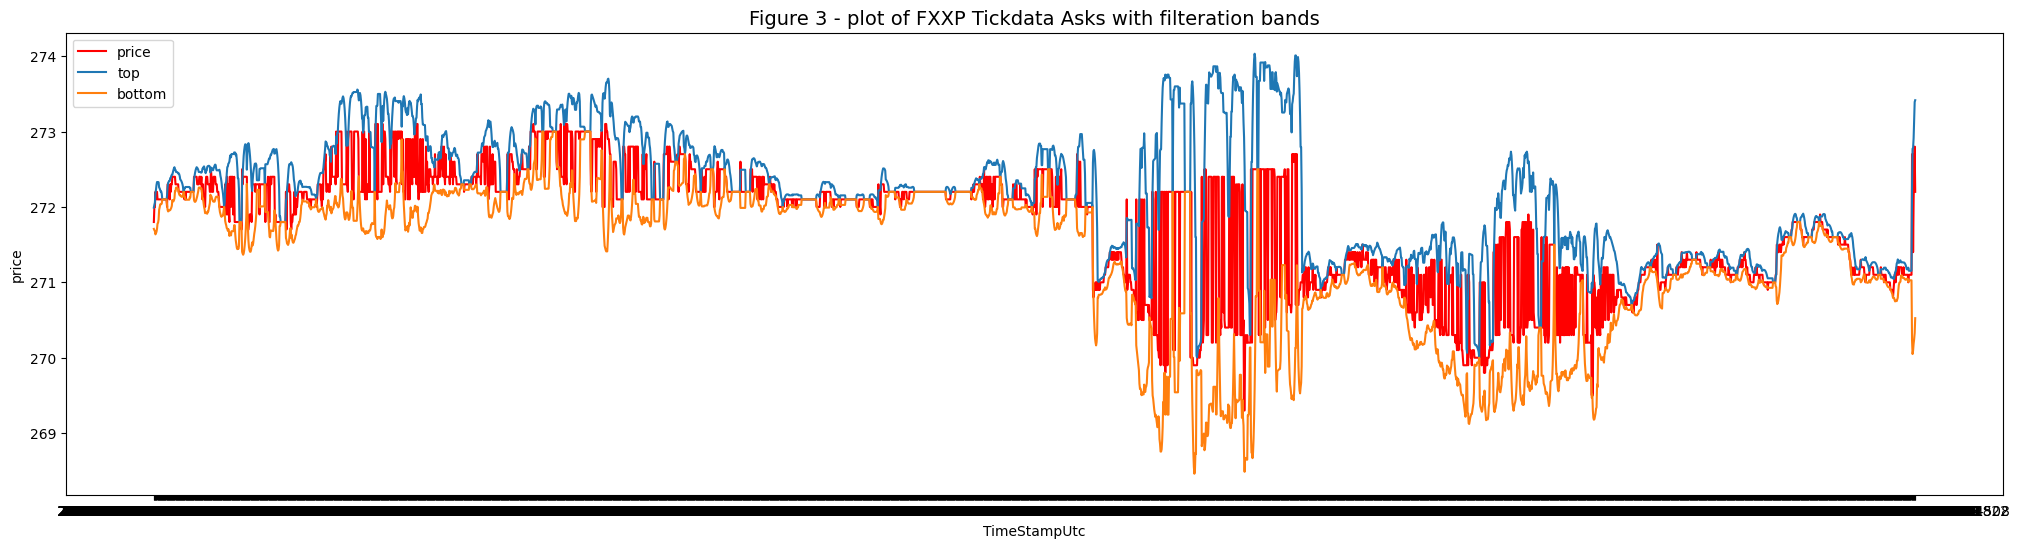

In [ ]:
if len(df3_ask) > 20 :

    df3_ask['rolling_median_3']=df3_ask['Value'].rolling(3).median()
    df3_ask['rolling_mean_10']=df3_ask['Value'].rolling(10).mean()
    df3_ask['rolling_std_10']=df3_ask['Value'].rolling(10).std()

    df3_ask = df3_ask.dropna()

    df3_ask['topline'] = df3_ask['rolling_mean_10'] + 2*df3_ask['rolling_std_10']
    df3_ask['bottomline'] = df3_ask['rolling_mean_10'] - 2*df3_ask['rolling_std_10']
    df3_ask_filtered = df3_ask[df3_ask['Value'] <= df3_ask['topline']]
    df3_ask_filtered = df3_ask[df3_ask['Value'] > df3_ask['bottomline']]

    #let's plot the asks
    plt.plot(df3_ask['TimestampUtc'], df3_ask['Value'],label="price", color ='red' )
    plt.plot(df3_ask['TimestampUtc'], df3_ask['topline'],label="top" )
    plt.plot(df3_ask['TimestampUtc'], df3_ask['bottomline'],label="bottom" )
    plt.xlabel("TimeStampUtc", fontsize=10)
    plt.ylabel("price", fontsize=10)


    plt.title(f"Figure 3 - plot of FXXP Tickdata Asks with filteration bands",fontsize =14)
    plt.legend(loc="upper left")
    plt.rcParams['figure.figsize'] = [25, 6]

    plt.show()

else:
    df3_ask_filtered = df3_ask.copy()
    print("----not enough asks to filter------")  #debug


Last we look at Trades

In [ ]:
if len(df3_trade) > 20 :
    df3_trade['rolling_median_3']=df3_trade['Value'].rolling(3).median()
    df3_trade['rolling_mean_10']=df3_trade['Value'].rolling(10).mean()
    df3_trade['rolling_std_10']=df3_trade['Value'].rolling(10).std()

    df3_trade = df3_trade.dropna()

    df3_trade['topline'] = df3_trade['rolling_mean_10'] + 2*df3_trade['rolling_std_10']
    df3_trade['bottomline'] = df3_trade['rolling_mean_10'] - 2*df3_trade['rolling_std_10']
    df3_trade_filtered = df3_trade[df3_trade['Value'] <= df3_trade['topline']]
    df3_trade_filtered = df3_trade[df3_trade['Value'] > df3_trade['bottomline']]

    #let's plot the trades
    plt.plot(df3_trade['TimestampUtc'], df3_trade['Value'],label="price", color='pink' )
    plt.plot(df3_trade['TimestampUtc'], df3_trade['topline'],label="top" )
    plt.plot(df3_trade['TimestampUtc'], df3_trade['bottomline'],label="bottom" )
    plt.xlabel("TimeStampUtc", fontsize=10)
    plt.ylabel("price", fontsize=10)

    plt.title(f"Plot of MNI Tickdata Trade",fontsize =14)
    plt.xticks(rotation=90)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=10)
    plt.legend(loc="upper left")
else:
    df3_trade_filtered = df3_trade.copy()
    print("----not enough trades to filter------")  #debug

----not enough trades to filter------


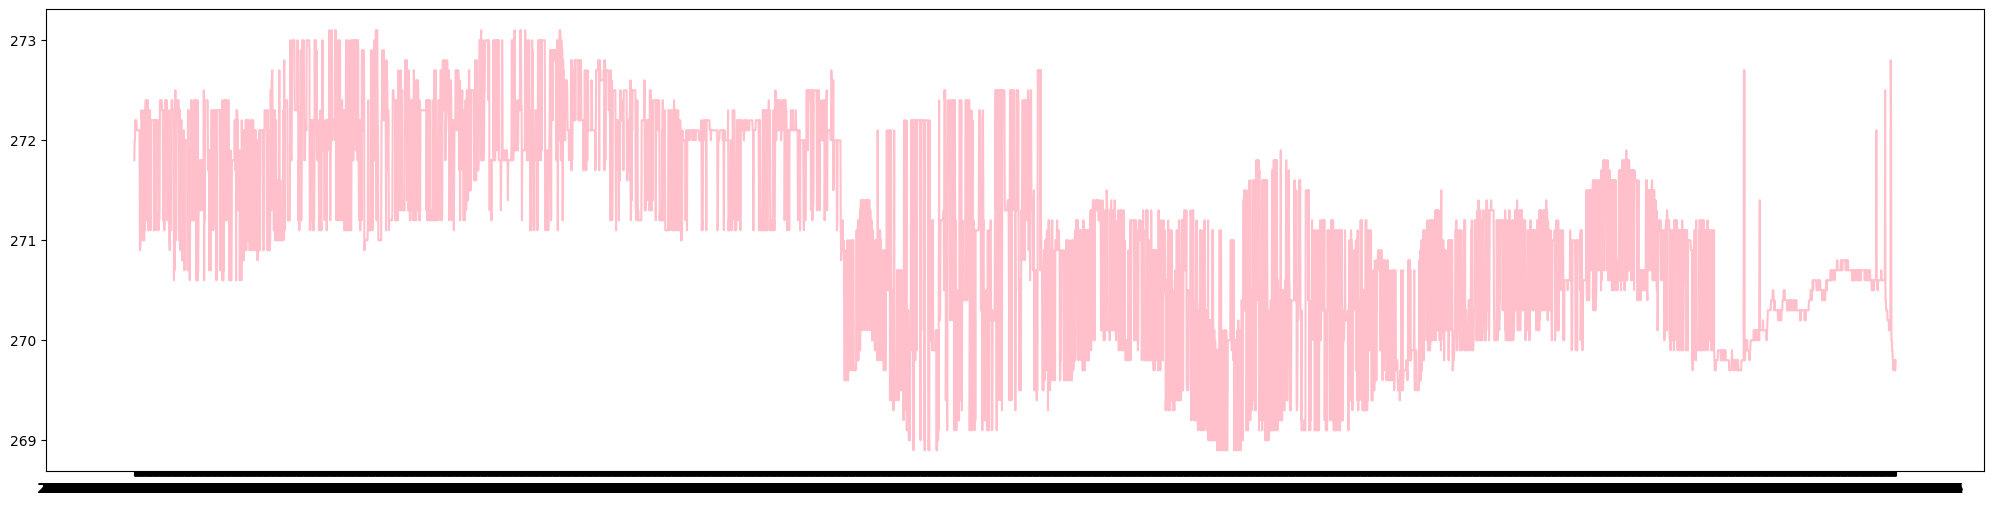

In [ ]:
#unioning the two dataframes
df3_reunited = pd.concat([df3_bid_filtered,df3_ask_filtered, df3_trade_filtered])

#and bringing back the original sort
df3_final = df3_reunited.sort_values(by=['Index'])

#let's plot this again
plt.plot(df3_final['TimestampUtc'], df3_final['Value'],label="filtered data", color = 'green')
plt.show()

